<img src="fifa.jpeg" style="float:left">

# Fifa 19 Dataset - Transfer Value predicting Regression Model

# Importing required Packages

In [2]:

import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from mosaicml import *
from mosaicml.constants import MLModelFlavours

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.

# Loading Dataset

In [3]:
# Load the data
data = pd.read_csv("/data/fifa.csv")
data.head(10)

,short_name,nationality,overall,potential,wage_eur,value_eur,age,height_cm,weight_kg,attacking_crossing,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,L. Messi,Argentina,94,94,565000,95500000,32,170,72,88,...,75,96,33,37,26,6,11,15,14,8
1,Cristiano Ronaldo,Portugal,93,93,405000,58500000,34,187,83,84,...,85,95,28,32,24,7,11,15,14,11
2,Neymar Jr,Brazil,92,92,290000,105500000,27,175,68,87,...,90,94,27,26,29,9,9,15,15,11
3,J. Oblak,Slovenia,91,93,125000,77500000,26,188,87,13,...,11,68,27,12,18,87,92,78,90,89
4,E. Hazard,Belgium,91,91,470000,90000000,28,175,74,81,...,88,91,34,27,22,11,12,6,8,8
5,K. De Bruyne,Belgium,91,91,370000,90000000,28,181,70,93,...,79,91,68,58,51,15,13,5,10,13
6,M. ter Stegen,Germany,90,93,250000,67500000,27,187,85,18,...,25,70,25,13,10,88,85,88,88,90
7,V. van Dijk,Netherlands,90,91,200000,78000000,27,193,92,53,...,62,89,91,92,85,13,10,13,11,11
8,L. Modric,Croatia,90,90,340000,45000000,33,172,66,86,...,82,92,68,76,71,13,9,7,14,9
9,M. Salah,Egypt,90,90,240000,80500000,27,175,71,79,...,77,91,38,43,41,14,14,9,11,14


# Seperating Dataset into Training and Test

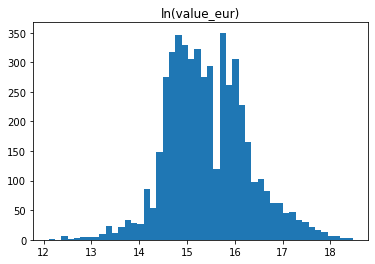

In [4]:
X = data[['age','height_cm','weight_kg','skill_dribbling','attacking_crossing','attacking_finishing','movement_acceleration','movement_sprint_speed','power_shot_power','mentality_aggression','defending_marking','defending_standing_tackle','goalkeeping_diving','goalkeeping_handling','overall','potential']]
y = data['value_eur']
ylog = np.log(y)

%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(ylog, bins='auto')
plt.title("ln(value_eur)")
plt.show()

X_train, X_test, ylog_train, ylog_test, y_train, y_test = train_test_split(X, ylog, y, test_size=0.25, random_state=4)

# Training the Model

In [5]:
gbm_default = GradientBoostingRegressor()
gbm_default.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

# Defining a Score Function

In [6]:
@scoring_func
def score(model, request):
    payload = request.json["payload"]
    data_list = payload
    data_array = np.asarray(data_list)
    try:
        prediction = model.predict(data_array)
    except:
        prediction = model.predict(data_array.reshape(1, -1))
    return prediction.tolist()


# Testing Score Function

In [6]:
# to verify if score func works

import requests
req = requests.Request()
req.json = {"payload":X_test}

'''
Reference Sample Payload 

req.json = {"payload": [ 25, 185,  88,  78,  65,  81,  77,  75,  81,  63,  37,  26,   9,
        10,  79,  82]}
        
'''
score(gbm_default, req)

[7371874.661681471,
 4738569.183719676,
 21420646.724212058,
 18565368.234815326,
 2521068.456590735,
 4927893.686116417,
 17717792.640952602,
 536649.2767679226,
 5379405.813943993,
 2782661.685757642,
 3109098.804303744,
 3854078.9689723533,
 4098721.5563835083,
 7769807.652539339,
 4692304.372048859,
 16930281.548238754,
 3473019.6617231495,
 6661265.394274317,
 3016063.3275525426,
 10421430.298660977,
 1978920.7122082587,
 2802425.7801835793,
 905938.380107172,
 7703026.231638118,
 4737163.454637373,
 9200545.134584036,
 40671774.995375425,
 11732600.005104976,
 11769365.62812942,
 127060.88757149669,
 5192798.597258348,
 3933793.16651854,
 2461772.794033603,
 17703016.395034228,
 5660456.160853365,
 2502423.505083093,
 6259869.183645455,
 8698457.579092512,
 1833849.8102294598,
 4711891.257815068,
 2820859.9746349426,
 2385315.8941515293,
 1986428.0458969302,
 7220836.170301252,
 2028027.9431738046,
 1953495.1905439007,
 3606521.7807429805,
 2197176.334081368,
 6941085.884180221,


# Calculating Y_true and Y_pred

In [7]:
Y_true = y_test

Y_pred = gbm_default.predict(X_test)
features = list(X_train)

# Registering the Model

In [8]:
register_model(
    gbm_default,
    score,
    "fifa_model3",
    "fifa_regression",
    MLModelFlavours.sklearn,
    init_script="mkdir abc \\n cd abc \\n touch abc.txt",
    input_type="json",
    explain_ai=True,
    x_train=X_train, 
    y_train=y_train, 
    y_true=Y_true,
    y_pred=Y_pred,
    feature_names=features,
    feature_ids=features,
    target_names=["Value"],
    model_type="regression"
)

Calculating build time metrics

Progress: ██████████████████████████████████████████████████████████████████████ 100.0%


2021-11-18 13:52:43,745 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False
2021-11-18 13:52:43,747 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[25/25] grid cells ████████████████████ Time elapsed: 0 seconds

2021-11-18 13:52:45,367 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False
2021-11-18 13:52:45,370 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[22/22] grid cells ████████████████████ Time elapsed: 0 seconds

2021-11-18 13:52:47,005 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False
2021-11-18 13:52:47,007 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[22/22] grid cells ████████████████████ Time elapsed: 0 seconds

2021-11-18 13:52:48,603 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False
2021-11-18 13:52:48,605 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[27/27] grid cells ████████████████████ Time elapsed: 0 seconds

2021-11-18 13:52:50,308 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False
2021-11-18 13:52:50,310 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[29/29] grid cells ████████████████████ Time elapsed: 0 seconds

2021-11-18 13:52:52,200 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False
2021-11-18 13:52:52,202 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[30/30] grid cells ████████████████████ Time elapsed: 0 seconds

2021-11-18 13:52:54,023 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False
2021-11-18 13:52:54,025 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[30/30] grid cells ████████████████████ Time elapsed: 0 seconds

2021-11-18 13:52:55,811 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False
2021-11-18 13:52:55,813 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[30/30] grid cells ████████████████████ Time elapsed: 0 seconds

2021-11-18 13:52:57,741 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False
2021-11-18 13:52:57,743 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[27/27] grid cells ████████████████████ Time elapsed: 0 seconds

2021-11-18 13:52:59,606 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False
2021-11-18 13:52:59,608 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[29/29] grid cells ████████████████████ Time elapsed: 0 seconds

2021-11-18 13:53:01,391 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False
2021-11-18 13:53:01,393 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[29/29] grid cells ████████████████████ Time elapsed: 0 seconds

2021-11-18 13:53:03,104 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False
2021-11-18 13:53:03,106 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[28/28] grid cells ████████████████████ Time elapsed: 0 seconds

2021-11-18 13:53:04,820 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False
2021-11-18 13:53:04,822 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[13/13] grid cells ████████████████████ Time elapsed: 0 seconds

2021-11-18 13:53:06,104 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False
2021-11-18 13:53:06,107 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[13/13] grid cells ████████████████████ Time elapsed: 0 seconds

2021-11-18 13:53:07,504 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False
2021-11-18 13:53:07,506 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[24/24] grid cells ████████████████████ Time elapsed: 0 seconds

2021-11-18 13:53:09,102 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False
2021-11-18 13:53:09,104 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[26/26] grid cells ████████████████████ Time elapsed: 0 seconds

2021-11-18 13:53:10,498 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False
2021-11-18 13:53:10,501 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[16/16] features ████████████████████ Time elapsed: 2 seconds

2021-11-18 13:53:14,030 - skater.core.global_interpretation.tree_surrogate - INFO - post pruning applied ...
2021-11-18 13:53:14,053 - skater.core.global_interpretation.tree_surrogate - INFO - Scorer used MAE
2021-11-18 13:53:14,054 - skater.core.global_interpretation.tree_surrogate - INFO - original score using base model 516013.78608318226
2021-11-18 13:53:14,169 - skater.core.global_interpretation.tree_surrogate - INFO - Summary: childrens of the following nodes are removed []
2021-11-18 13:53:14,171 - skater.core.global_interpretation.tree_surrogate - INFO - Done generating prediction using the surrogate, shape (3750,)
2021-11-18 13:53:14,173 - skater.core.global_interpretation.tree_surrogate - INFO - Done scoring, surrogate score 516013.786; oracle score 324673.818
